In [3]:
import pandas as pd
import datetime as dt
import backtrader as bt
import quantstats as qs
import matplotlib as plt
import numpy as np
import os
import pathlib
os.getcwd()

#数据加载-------------------------------------
df=pd.read_csv(pathlib.Path.cwd() / ".." / "data"/ "testCSI300.csv")
df.index=pd.to_datetime(df.date)
df['openinterest']=0

#以下是自己随机添加signal的之后的文件，hmm算法给出的带signal的文件直接用上面的df=pd.read_csv导入，把下面到构建策略之前mute掉即可

# 随机生成一个-1，0，1的predictions序列---------
# sig=[]
# for i in range(len(df)):
#     x=np.random.randn()
#     if x > 0.2:
#         sig.append(1)
#     elif x<-0.2:
#         sig.append(-1)
#     else:
#         sig.append(0)
# df['signal']=sig



#构建策略-------------------------------------
class TestSignalStrategy(bt.Strategy):
    params=()

    def log(self,txt,dt=None):
        dt= dt or self.datetime.date(0)
        print('%s,%s' % (dt.isoformat(),txt)) 

    def __init__(self):
        self.bar_num=0
        self.signal_df=df
        self.signal_df['date']=pd.to_datetime(self.signal_df['date'])
        self.first_trade=True

    def prenext(self):
        self.next()

    def next(self):
        self.bar_num+=1
        current_date=self.datas[0].datetime.date(0).strftime("%Y-%m-%d")
        try:
            next_date =self.datas[0].datetime.date(1)
        except:
            next_date=None
        if next_date != None:
            next_signal_df= self.signal_df[self.signal_df['date']==pd.to_datetime(next_date)]
            if len(next_signal_df)==0:
                self.log("下个交易日的信号不存在")
            else:
                signal = int(next_signal_df['signal'])
                
                #第一次交易没有底仓，只允许做多
                #交易信号的执行方式：
                #先不考虑卖空
                #signal为1，以当天开盘价全仓买入
                #signal为-1时，以当天开盘价卖出所有持仓
                if self.first_trade:
                    if signal==-1:
                        pass
                    if signal == 1:
                        total_value = self.broker.get_value()
                        open_price = self.datas[0].open[0]
                        target_size=total_value//open_price
                        self.buy(self.datas[0],size=target_size,price=open_price)
                        self.first_trade=False
                else:
                    #现有持仓
                    now_hold_size = self.getposition(self.datas[0]).size
                    if signal == 1:
                        total_value = self.broker.get_value()
                        open_price = self.datas[0].open[0]
                        target_size=total_value//open_price
                        self.buy(self.datas[0],size=target_size, price=open_price)

                    if signal == -1:
                        total_value = self.broker.get_value()
                        open_price = self.datas[0].open[0]
                        target_size=total_value//open_price
                        #卖出开仓，手数不能超过底仓
                        if target_size>now_hold_size:
                            target_size=now_hold_size

                        self.sell(self.datas[0],size=target_size, price=open_price)

    #订单情况
    def notify_order(self, order):
        
        #订单处于未决，继续
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        #订单已决
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('买单执行,%.2f' % order.executed.price)

            elif order.issell():
                self.log('卖单执行,%2f' % order.executed.price)
        
        elif order.status in [order.Canceled,order.Rejected,order.Expired]:
            self.log('订单 Canceled/Rejected/Expired')

    #交易情况
    def notify_trade(self, trade):
        if trade.isclosed:
            print('毛收益 %0.2f, 扣佣后收益 % 0.2f , 佣金 %.2f'
            % (trade.pnl, trade.pnlcomm, trade.commission))
        


cerebro=bt.Cerebro()

stock_df=df[['open','high','low','close','volume','openinterest']]


In [4]:
data=bt.feeds.PandasData(dataname=stock_df,fromdate=dt.datetime(2014, 3, 7), todate=dt.datetime(2021, 12, 30),timeframe=bt.TimeFrame.Days)
cerebro.adddata(data)

#滑点设置 0.5%
cerebro.broker = bt.brokers.BackBroker(slip_perc=0.005)
#初始资金设置为10万
cerebro.broker.setcash(100000.0)
#手续费万分之二
cerebro.broker.setcommission(commission=0.0002)

cerebro.addstrategy(TestSignalStrategy)
cerebro.addanalyzer(bt.analyzers.PyFolio,_name='PyFolio')

#运行回测
print('start portfolio value:',format(cerebro.broker.getvalue()))
results = cerebro.run()
print('end portfolio value:',format(cerebro.broker.getvalue()))


#绩效评价----------------------------
#获取策略实例
start = results[0]
portfolio_stats = start.analyzers.getbyname('PyFolio')
#以下returns为以日期为索引的资产日收益率序列
returns,positions,transactions,gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)

start portfolio value: 100000.0
2014-03-25,买单执行,2170.78
2014-04-04,卖单执行,2157.980000
2014-04-21,卖单执行,2209.940000
毛收益 -536.84, 扣佣后收益 -576.67 , 佣金 39.83
2014-05-14,买单执行,2175.09
2014-05-22,卖单执行,2134.090000
毛收益 -1845.00, 扣佣后收益 -1883.78 , 佣金 38.78
2014-05-30,买单执行,2156.38
2014-06-05,卖单执行,2126.610000
毛收益 -1309.88, 扣佣后收益 -1347.57 , 佣金 37.69
2014-06-13,买单执行,2150.99
2014-06-20,卖单执行,2124.960000
毛收益 -1145.32, 扣佣后收益 -1182.95 , 佣金 37.63
2014-07-02,买单执行,2164.00
2014-07-11,卖单执行,2136.320000
毛收益 -1190.24, 扣佣后收益 -1227.22 , 佣金 36.98
2014-07-21,买单执行,2164.22
2014-08-15,卖单执行,2337.990000
2014-08-18,卖单执行,2366.270000
毛收益 7500.39, 扣佣后收益  7461.67 , 佣金 38.72
2014-08-19,买单执行,2378.89
2014-08-27,卖单执行,2323.790000
毛收益 -2314.20, 扣佣后收益 -2353.70 , 佣金 39.50
2014-09-09,买单执行,2452.23
2014-09-17,卖单执行,2395.360000
2014-09-18,卖单执行,2396.380000
毛收益 -2273.78, 扣佣后收益 -2312.56 , 佣金 38.78
2014-09-26,买单执行,2430.81
2014-10-20,卖单执行,2448.450000
毛收益 687.96, 扣佣后收益  649.90 , 佣金 38.06
2014-10-31,买单执行,2473.50
2014-11-21,卖单执行,2537.540000
毛收益 2497.5

2021-10-29,卖单执行,4861.270000
毛收益 -2320.58, 扣佣后收益 -2377.43 , 佣金 56.85
2021-11-15,买单执行,4894.41
2021-12-01,卖单执行,4831.890000
毛收益 -1813.08, 扣佣后收益 -1869.49 , 佣金 56.41
2021-12-08,买单执行,4934.41
2021-12-21,卖单执行,4876.510000
毛收益 -1621.20, 扣佣后收益 -1676.14 , 佣金 54.94
end portfolio value: 139370.34120600007


                    Strategy
------------------  ----------
Start Period        2014-03-07
End Period          2021-12-30
Risk-Free Rate      0.0%
Time in Market      60.0%

Cumulative Return   39.37%
CAGR﹪              4.34%

Sharpe              0.39
Sortino             0.55
Sortino/√2          0.39
Omega               1.1

Max Drawdown        -31.18%
Longest DD Days     1864

Gain/Pain Ratio     0.1
Gain/Pain (1M)      0.34

Payoff Ratio        1.07
Profit Factor       1.1
Common Sense Ratio  1.26
CPC Index           0.6
Tail Ratio          1.15
Outlier Win Ratio   8.39
Outlier Loss Ratio  3.93

MTD                 -1.21%
3M                  -4.08%
6M                  -12.95%
YTD                 -13.94%
1Y                  -11.07%
3Y (ann.)           5.64%
5Y (ann.)           2.86%
10Y (ann.)          4.34%
All-time (ann.)     4.34%

Avg. Drawdown       -5.1%
Avg. Drawdown Days  139
Recovery Factor     1.26
Ulcer Index         0.18
Serenity Index      0.07


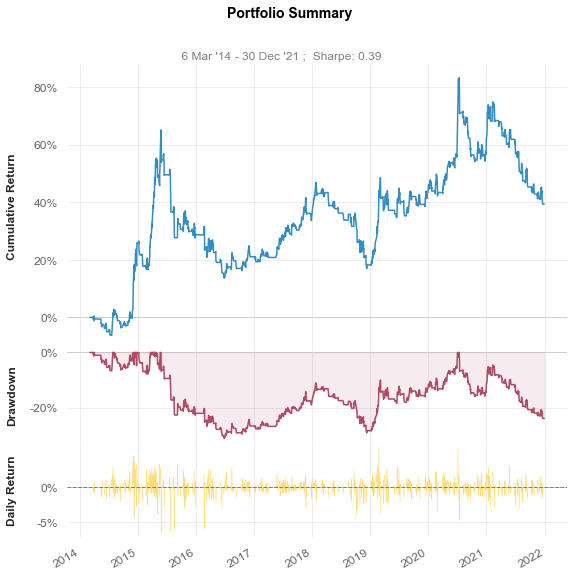

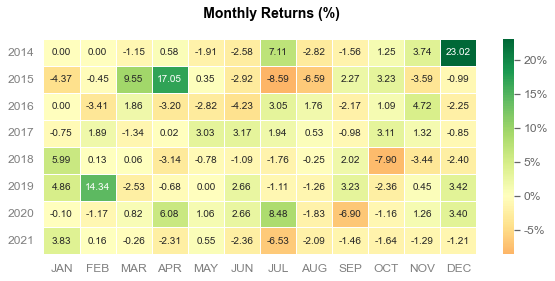

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2014-03-07  2014-03-07
End Period                 2021-12-30  2021-12-30
Risk-Free Rate             0.0%        0.0%
Time in Market             60.0%       100.0%

Cumulative Return          39.37%      126.97%
CAGR﹪                     4.34%       11.05%

Sharpe                     0.39        0.58
Smart Sharpe               0.37        0.56
Sortino                    0.55        0.8
Smart Sortino              0.52        0.76
Sortino/√2                 0.39        0.57
Smart Sortino/√2           0.37        0.54
Omega                      1.1         1.1

Max Drawdown               -31.18%     -46.7%
Longest DD Days            1864        2037
Volatility (ann.)          13.85%      23.13%
R^2                        0.37        0.37
Calmar                     0.14        0.24
Skew                       -0.43       -0.75
Kurtosis                   11.28       5

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-05-27,2016-06-27,2020-07-03,1864,-31.180053,-30.141160
2,2020-07-14,2021-12-21,2021-12-30,534,-23.970757,-23.896136
3,2015-01-08,2015-03-06,2015-03-23,74,-7.834794,-7.829318
4,2014-04-03,2014-07-11,2014-07-28,116,-6.626920,-6.556401
5,2014-08-05,2014-09-16,2014-12-02,119,-6.341106,-6.102070


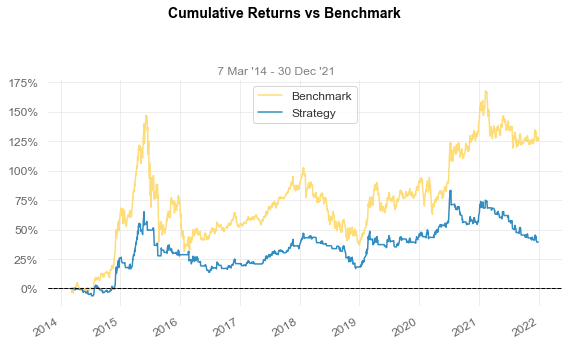

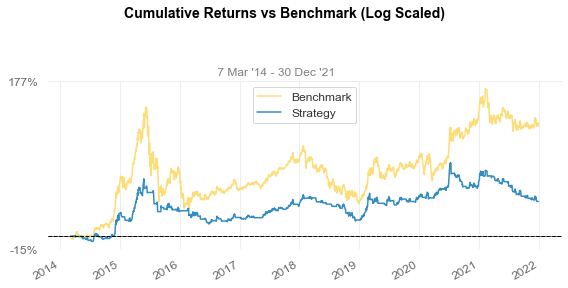

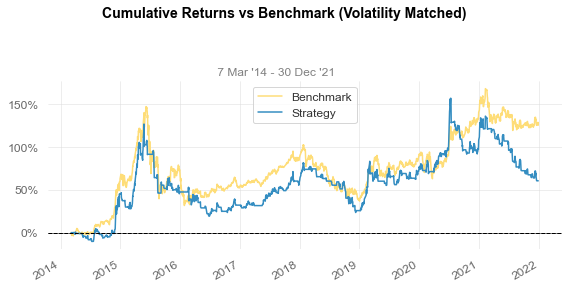

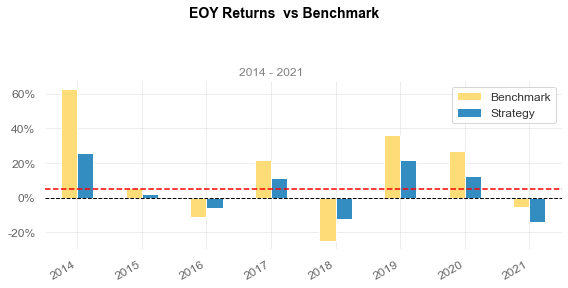

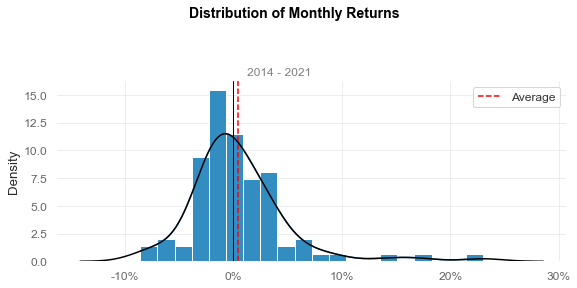

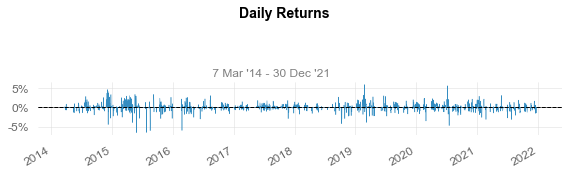

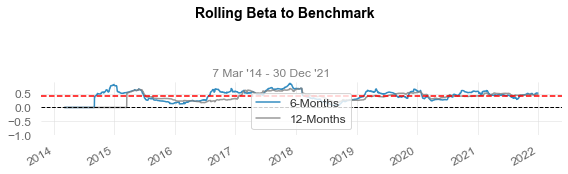

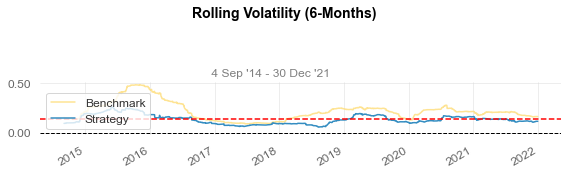

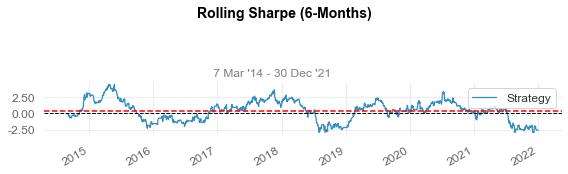

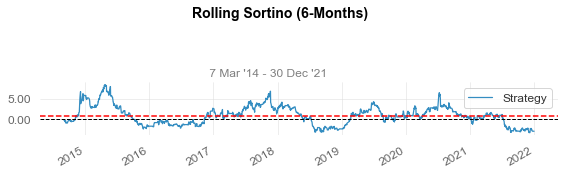

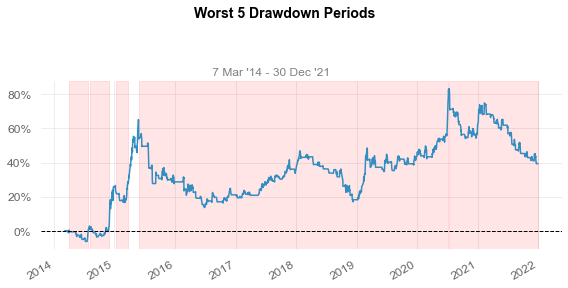

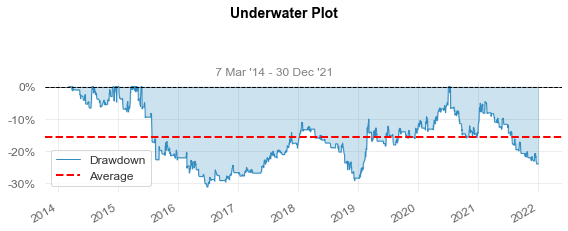

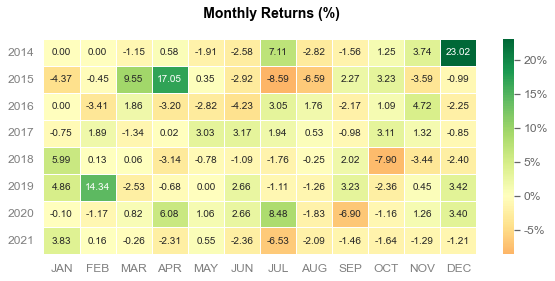

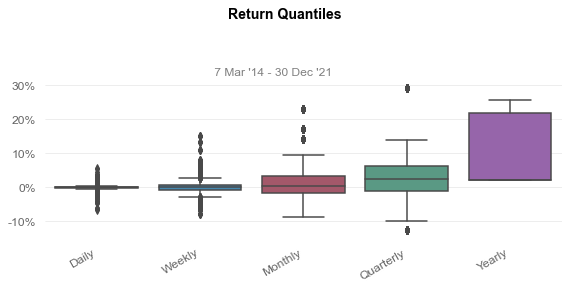

In [6]:
#画图仍只能在notebook中输出(将basic改成full的话可以得到更多的输出结果，但其中一个return distribution的表会报错)
qs.reports.basic(returns,rf=0.0,grayscale=False,display=True,compounded = True)
#只有在full中有和benchmark的对比
qs.reports.full(returns,benchmark=stock_df['close'],rf=0.0,grayscale=False,display=True,compounded = True)